## 🔹 Objective:
__Apply PCA to reduce dimensionality and train classic ML models (SVC, Random Forest, etc.)__

In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Helper Methods

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import time
import re

# 0. 🔹 Extract model based on name
def extract_model_key(model_name):
    """
    Extracts base model name like 'svc', 'rf', 'mlp' from strings like 'svc_95', 'rf_98'
    """
    match = re.search(r'(svc|rf|mlp)', model_name.lower())
    return match.group(1) if match else None


# 1. 🔹 Load and Preprocess Data
def load_and_clean_data(path='data/train.csv', threshold=0.95):
    df = pd.read_csv(path)
    X = df.drop('label', axis=1) / 255.0
    y = df['label']
    
    # ✅ 1. Drop Sparse/Dead Pixels
    # Remove pixel columns where more than 95% of values are 0.
    
    zero_mask = (X == 0).sum(axis=0) / len(X) > 0.95
    X_reduced = X.loc[:, ~zero_mask]  # Keep only informative pixels
    
    print(f"Reduced from {X.shape[1]} to {X_reduced.shape[1]} features")
    X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.1, random_state=42, stratify=y)
    return X_train, X_val, y_train, y_val, zero_mask

# 2. 🔧 Pipeline Constructor
def get_pipeline(model_name='svc', model=None, n_components=0.95):
    model_key = extract_model_key(model_name)
    steps = [
        ('pca', PCA(n_components=n_components, random_state=42)),
        ('scaler', StandardScaler()),
        (model_name, model)
    ]
    return Pipeline(steps)

# 3. 📊 Example Hyperparameter Grids
def get_param_distributions(model_name):
    model_key = extract_model_key(model_name)
    if model_key == 'svc':
        return {
            f'{model_name}__C': [10, 100],
            f'{model_name}__kernel': ['rbf', 'linear'],
            f'{model_name}__gamma': ['scale', 'auto']
        }
    elif model_key == 'rf':
        return {
            f'{model_name}__n_estimators': [100, 200, 300],
            f'{model_name}__max_depth': [10, 20, 50],
            f'{model_name}__min_samples_split': [2, 5, 10]
        }
    elif model_key == 'mlp':
        return {
            f'{model_name}__hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64)],
            f'{model_name}__activation': ['relu', 'tanh'],
            f'{model_name}__solver': ['adam', 'sgd'],
            f'{model_name}__alpha': [1e-4, 1e-3, 1e-2],
            f'{model_name}__learning_rate': ['constant', 'adaptive']
        }
    else:
        return {}

# 4. 🚀 Train Model with RandomizedSearchCV
def run_random_search(pipeline, param_dist, X_train, X_val, y_train, y_val, model_name):
    start = time.time()

    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=5,
        scoring='accuracy',
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train, y_train)

    end = time.time()
    duration = end - start

    print(f"⏱️ Training time: {duration:.2f} seconds")
    print(f"🏆 Best Params for {model_name}: {search.best_params_}")
    print(f"✅ Best CV Accuracy: {search.best_score_:.4f}")

    # Evaluate on validation set
    y_pred = search.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print("📊 Validation Accuracy:", acc)
    print("📄 Classification Report:")
    print(classification_report(y_val, y_pred))

    return {
        "model_name": model_name,
        "accuracy": acc,
        "training_time": duration,
        "report": classification_report(y_val, y_pred, output_dict=True),
        "model": search
    }

# 5. Prepare test data
def prepare_test_data(path='data/test.csv', zero_mask=None):
    test_df = pd.read_csv(path) / 255.0
    if zero_mask is not None:
        test_df = test_df.loc[:, ~zero_mask]
    return test_df


### SVC with 0.95 varience of PCA

In [3]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

X_train, X_val, y_train, y_val, zero_mask  = load_and_clean_data(path='/kaggle/input/digit-recognizer/train.csv')

model = SVC(max_iter=5000)
pipeline = get_pipeline('svc_95', model)
param_dist = get_param_distributions('svc_95')

result_svc_95 = run_random_search(pipeline, param_dist, X_train, X_val, y_train, y_val, 'svc_95')

Reduced from 784 to 398 features
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END svc_95__C=10, svc_95__gamma=scale, svc_95__kernel=linear; total time=  49.1s
[CV] END svc_95__C=10, svc_95__gamma=scale, svc_95__kernel=linear; total time=  51.3s
[CV] END svc_95__C=100, svc_95__gamma=scale, svc_95__kernel=linear; total time=  51.3s
[CV] END svc_95__C=10, svc_95__gamma=scale, svc_95__kernel=linear; total time=  52.7s


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END svc_95__C=100, svc_95__gamma=scale, svc_95__kernel=linear; total time=  49.0s
[CV] END svc_95__C=100, svc_95__gamma=scale, svc_95__kernel=linear; total time=  51.9s


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END svc_95__C=100, svc_95__gamma=auto, svc_95__kernel=linear; total time=  40.7s


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END svc_95__C=10, svc_95__gamma=scale, svc_95__kernel=rbf; total time= 2.1min
[CV] END svc_95__C=10, svc_95__gamma=scale, svc_95__kernel=rbf; total time= 2.1min
[CV] END svc_95__C=100, svc_95__gamma=auto, svc_95__kernel=linear; total time=  40.4s
[CV] END svc_95__C=10, svc_95__gamma=scale, svc_95__kernel=rbf; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END svc_95__C=100, svc_95__gamma=auto, svc_95__kernel=linear; total time=  46.8s
[CV] END svc_95__C=10, svc_95__gamma=auto, svc_95__kernel=rbf; total time= 1.7min
[CV] END svc_95__C=10, svc_95__gamma=auto, svc_95__kernel=rbf; total time= 1.7min
[CV] END svc_95__C=10, svc_95__gamma=auto, svc_95__kernel=rbf; total time= 1.5min
⏱️ Training time: 344.87 seconds
🏆 Best Params for svc_95: {'svc_95__kernel': 'rbf', 'svc_95__gamma': 'scale', 'svc_95__C': 10}
✅ Best CV Accuracy: 0.9716
📊 Validation Accuracy: 0.9764285714285714
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       413
           1       1.00      0.99      1.00       468
           2       0.97      0.98      0.97       418
           3       0.96      0.97      0.97       435
           4       0.99      0.97      0.98       407
           5       0.96      0.97      0.96       380
           6       0.98      1.00      0.99       414
           7 

### SVC with 0.98 varience

In [4]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

X_train, X_val, y_train, y_val, zero_mask = load_and_clean_data(path='/kaggle/input/digit-recognizer/train.csv',threshold = 0.98)

model = SVC(max_iter=5000)
pipeline = get_pipeline('svc_98', model)
param_dist = get_param_distributions('svc_98')

result_svc_98 = run_random_search(pipeline, param_dist, X_train, X_val, y_train, y_val, 'svc_98')

Reduced from 784 to 398 features
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END svc_98__C=10, svc_98__gamma=scale, svc_98__kernel=linear; total time=  47.8s
[CV] END svc_98__C=10, svc_98__gamma=scale, svc_98__kernel=linear; total time=  48.7s
[CV] END svc_98__C=100, svc_98__gamma=scale, svc_98__kernel=linear; total time=  51.1s
[CV] END svc_98__C=10, svc_98__gamma=scale, svc_98__kernel=linear; total time=  51.8s


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END svc_98__C=100, svc_98__gamma=scale, svc_98__kernel=linear; total time=  48.9s
[CV] END svc_98__C=100, svc_98__gamma=scale, svc_98__kernel=linear; total time=  52.5s


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END svc_98__C=100, svc_98__gamma=auto, svc_98__kernel=linear; total time=  40.1s


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END svc_98__C=10, svc_98__gamma=scale, svc_98__kernel=rbf; total time= 2.0min
[CV] END svc_98__C=10, svc_98__gamma=scale, svc_98__kernel=rbf; total time= 2.0min
[CV] END svc_98__C=100, svc_98__gamma=auto, svc_98__kernel=linear; total time=  39.3s


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END svc_98__C=10, svc_98__gamma=scale, svc_98__kernel=rbf; total time= 1.9min
[CV] END svc_98__C=100, svc_98__gamma=auto, svc_98__kernel=linear; total time=  49.4s
[CV] END svc_98__C=10, svc_98__gamma=auto, svc_98__kernel=rbf; total time= 1.8min
[CV] END svc_98__C=10, svc_98__gamma=auto, svc_98__kernel=rbf; total time= 1.7min
[CV] END svc_98__C=10, svc_98__gamma=auto, svc_98__kernel=rbf; total time= 1.4min
⏱️ Training time: 346.57 seconds
🏆 Best Params for svc_98: {'svc_98__kernel': 'rbf', 'svc_98__gamma': 'scale', 'svc_98__C': 10}
✅ Best CV Accuracy: 0.9716
📊 Validation Accuracy: 0.9764285714285714
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       413
           1       1.00      0.99      1.00       468
           2       0.97      0.98      0.97       418
           3       0.96      0.97      0.97       435
           4       0.99      0.97      0.98       407
           5       0.96      0.97     

In [5]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

X_train, X_val, y_train, y_val, zero_mask = load_and_clean_data(path='/kaggle/input/digit-recognizer/train.csv',threshold = 0.95)

model = RandomForestClassifier(random_state = 42, warm_start = True)
pipeline = get_pipeline('rf_95', model)
param_dist = get_param_distributions('rf_95')

result_rf_95 = run_random_search(pipeline, param_dist, X_train, X_val, y_train, y_val, 'rf_95')

Reduced from 784 to 398 features
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END rf_95__max_depth=20, rf_95__min_samples_split=5, rf_95__n_estimators=200; total time= 1.6min
[CV] END rf_95__max_depth=10, rf_95__min_samples_split=10, rf_95__n_estimators=300; total time= 1.7min
[CV] END rf_95__max_depth=10, rf_95__min_samples_split=10, rf_95__n_estimators=300; total time= 1.7min
[CV] END rf_95__max_depth=10, rf_95__min_samples_split=10, rf_95__n_estimators=300; total time= 1.7min
[CV] END rf_95__max_depth=20, rf_95__min_samples_split=2, rf_95__n_estimators=100; total time=  49.2s
[CV] END rf_95__max_depth=20, rf_95__min_samples_split=2, rf_95__n_estimators=100; total time=  49.6s
[CV] END rf_95__max_depth=20, rf_95__min_samples_split=5, rf_95__n_estimators=200; total time= 1.6min
[CV] END rf_95__max_depth=20, rf_95__min_samples_split=2, rf_95__n_estimators=100; total time=  48.3s
[CV] END rf_95__max_depth=20, rf_95__min_samples_split=5, rf_95__n_estimators=200; total

In [7]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

X_train, X_val, y_train, y_val, zero_mask = load_and_clean_data(path='/kaggle/input/digit-recognizer/train.csv',threshold = 0.98)

model = RandomForestClassifier(random_state = 42, warm_start = True)
pipeline = get_pipeline('rf_98', model)
param_dist = get_param_distributions('rf_98')

result_rf_98 = run_random_search(pipeline, param_dist, X_train, X_val, y_train, y_val, 'rf_98')

Reduced from 784 to 398 features
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END rf_98__max_depth=20, rf_98__min_samples_split=5, rf_98__n_estimators=200; total time= 1.6min
[CV] END rf_98__max_depth=10, rf_98__min_samples_split=10, rf_98__n_estimators=300; total time= 1.7min
[CV] END rf_98__max_depth=10, rf_98__min_samples_split=10, rf_98__n_estimators=300; total time= 1.7min
[CV] END rf_98__max_depth=10, rf_98__min_samples_split=10, rf_98__n_estimators=300; total time= 1.7min
[CV] END rf_98__max_depth=20, rf_98__min_samples_split=2, rf_98__n_estimators=100; total time=  50.4s
[CV] END rf_98__max_depth=20, rf_98__min_samples_split=2, rf_98__n_estimators=100; total time=  50.3s
[CV] END rf_98__max_depth=20, rf_98__min_samples_split=5, rf_98__n_estimators=200; total time= 1.6min
[CV] END rf_98__max_depth=20, rf_98__min_samples_split=5, rf_98__n_estimators=200; total time= 1.6min
[CV] END rf_98__max_depth=20, rf_98__min_samples_split=2, rf_98__n_estimators=100; total

In [6]:
from sklearn.neural_network import MLPClassifier

X_train, X_val, y_train, y_val, zero_mask = load_and_clean_data(path='/kaggle/input/digit-recognizer/train.csv')

model = MLPClassifier(random_state=42, max_iter=500)
pipeline = get_pipeline('mlp', model)
param_dist = get_param_distributions('mlp')

result_mlp = run_random_search(pipeline, param_dist, X_train, X_val, y_train, y_val, 'mlp')

Reduced from 784 to 398 features
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(64,), mlp__learning_rate=constant, mlp__solver=adam; total time=  22.5s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(64,), mlp__learning_rate=constant, mlp__solver=adam; total time=  23.1s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(64,), mlp__learning_rate=constant, mlp__solver=adam; total time=  27.6s
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate=constant, mlp__solver=sgd; total time= 2.8min


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(64, 32), mlp__learning_rate=constant, mlp__solver=sgd; total time= 2.5min
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate=constant, mlp__solver=sgd; total time= 2.7min
[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate=constant, mlp__solver=sgd; total time= 2.7min
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate=adaptive, mlp__solver=adam; total time=  25.4s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate=adaptive, mlp__solver=adam; total time=  26.0s
[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate=adaptive, mlp__solver=adam; total time=  24.2s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(64, 32), mlp__learning_rate=constant, mlp__solver=sgd; total time= 2.4min


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(64, 32), mlp__learning_rate=constant, mlp__solver=sgd; total time= 2.5min
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(64,), mlp__learning_rate=constant, mlp__solver=sgd; total time= 1.9min
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(64,), mlp__learning_rate=constant, mlp__solver=sgd; total time= 1.8min
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(64,), mlp__learning_rate=constant, mlp__solver=sgd; total time= 1.2min
⏱️ Training time: 405.17 seconds
🏆 Best Params for mlp: {'mlp__solver': 'adam', 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (128, 64), 'mlp__alpha': 0.01, 'mlp__activation': 'tanh'}
✅ Best CV Accuracy: 0.9483
📊 Validation Accuracy: 0.9588095238095238
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       413
           1      

In [8]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [9]:
import joblib
import os

def save_model(model, model_name):
    os.makedirs("outputs/models", exist_ok=True)
    file_path = f"outputs/models/{model_name}.joblib"
    joblib.dump(model, file_path)
    print(f"✅ Model saved to {file_path}")

In [21]:
import pandas as pd

# Combine all results into a list
results = [result_svc_95, result_svc_98, result_rf_95, result_rf_98, result_mlp]

import json
import os

def export_summary(results):
    # Make sure output folder exists
    os.makedirs("outputs", exist_ok=True)
    os.makedirs("outputs/reports", exist_ok=True)
    
    # Save each report
    for res in results:
        report_path = f"outputs/reports/classification_report_{res['model_name']}.json"
        with open(report_path, "w") as f:
            json.dump(res["report"], f, indent=4)
        save_model(res['model'], res['model_name'])
    
    # Extract summary into a DataFrame
    summary = pd.DataFrame([
        {
            "Model": res["model_name"],
            "Accuracy": res["accuracy"],
            "Training Time (s)": res["training_time"],
            "Report Path": f"outputs/reports/classification_report_{res['model_name']}.json",
            "Model Path":  f"outputs/models/{res['model_name']}.joblib"
        }
        for res in results
    ])
    
    # Export summary as CSV
    summary.to_csv("outputs/model_summary.csv", index=False)
    
    print("✅ Model summary exported to outputs/model_summary.csv")

/tmp/ipykernel_160/2736355473.py:22: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


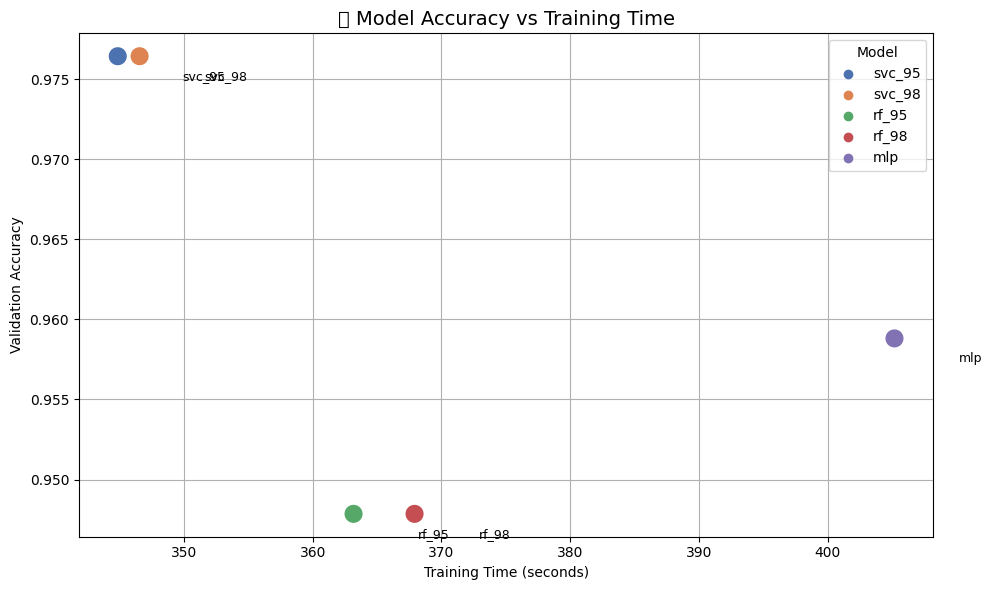

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=summary,
    x="Training Time (s)",
    y="Accuracy",
    hue="Model",
    s=200,
    palette="deep"
)

# Annotate model names
for i, row in summary.iterrows():
    plt.text(row["Training Time (s)"] + 5, row["Accuracy"] - 0.0015, row["Model"], fontsize=9)

plt.title("🔍 Model Accuracy vs Training Time", fontsize=14)
plt.xlabel("Training Time (seconds)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Filter comparisons
svc_comparison = summary[summary['Model'].str.contains('svc')]
rf_comparison = summary[summary['Model'].str.contains('rf')]

# Display side-by-side comparison
print("🔍 SVC Comparison (95% vs 98% PCA):")
print(svc_comparison.sort_values("Accuracy", ascending=False))

print("\n🌳 RF Comparison (95% vs 98% PCA):")
print(rf_comparison.sort_values("Accuracy", ascending=False))

🔍 SVC Comparison (95% vs 98% PCA):
    Model  Accuracy  Training Time (s)  \
0  svc_95  0.976429         344.869283   
1  svc_98  0.976429         346.566194   

                                         Report Path  \
0  outputs/reports/classification_report_svc_95.json   
1  outputs/reports/classification_report_svc_98.json   

                     Model Path  
0  outputs/models/svc_95.joblib  
1  outputs/models/svc_98.joblib  

🌳 RF Comparison (95% vs 98% PCA):
   Model  Accuracy  Training Time (s)  \
2  rf_95  0.947857         363.176512   
3  rf_98  0.947857         367.912493   

                                        Report Path  \
2  outputs/reports/classification_report_rf_95.json   
3  outputs/reports/classification_report_rf_98.json   

                    Model Path  
2  outputs/models/rf_95.joblib  
3  outputs/models/rf_98.joblib  


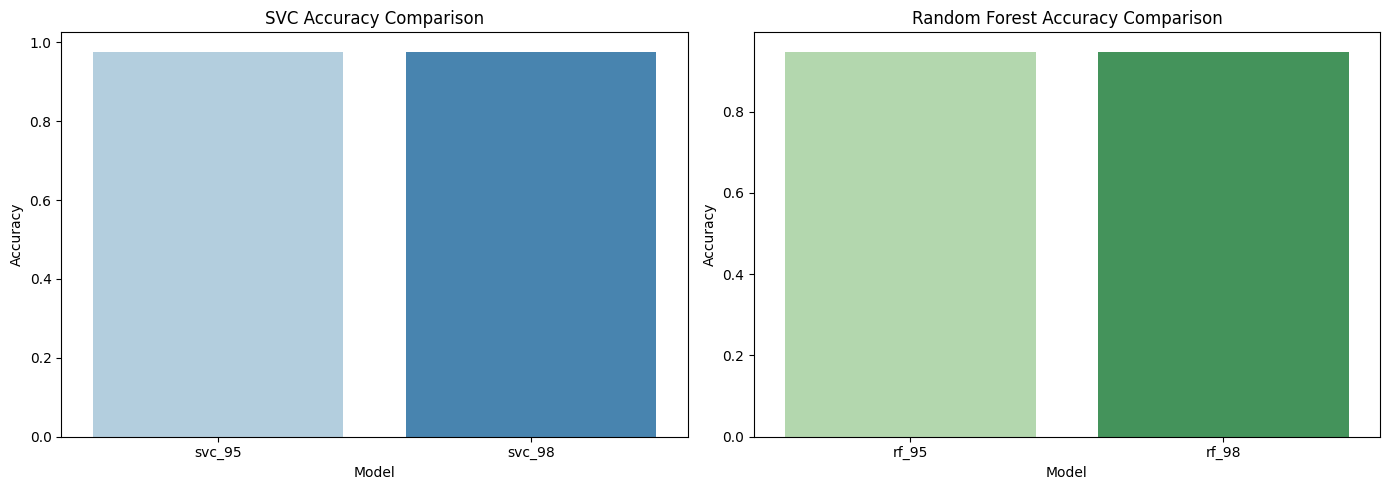

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SVC comparison
sns.barplot(ax=axes[0], data=svc_comparison, x="Model", y="Accuracy", palette="Blues")
axes[0].set_title("SVC Accuracy Comparison")

# RF comparison
sns.barplot(ax=axes[1], data=rf_comparison, x="Model", y="Accuracy", palette="Greens")
axes[1].set_title("Random Forest Accuracy Comparison")

plt.tight_layout()
plt.show()

## Ensemble Learning

In [18]:
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# 🧱 Step 1: Reconstruct base models
svc_pipe = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('scaler', StandardScaler()),
    ('svc_95', SVC(C=10, kernel='rbf', gamma='scale', probability=True))
])

rf_pipe = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('scaler', StandardScaler()),
    ('rf_95', RandomForestClassifier(n_estimators=200, min_samples_split=5, max_depth=20, random_state=42))
])

mlp_pipe = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(128, 64), activation='tanh',
                          solver='adam', alpha=0.01, learning_rate='adaptive',
                          max_iter=300, random_state=42))
])

# 🎯 Step 2: Build StackingClassifier
ensemble_model = StackingClassifier(
    estimators=[
        ('svc', svc_pipe),
        ('rf', rf_pipe),
        ('mlp', mlp_pipe)
    ],
    final_estimator=GradientBoostingClassifier(random_state=42),
    cv=3,
    n_jobs=-1,
    verbose=2
)

# 🚀 Step 3: Fit the ensemble
ensemble_model.fit(X_train, y_train)

# 📈 Evaluate on validation
y_pred = ensemble_model.predict(X_val)
acc = accuracy_score(y_val, y_pred)

print("📊 Ensemble Validation Accuracy:", acc)
print("📄 Classification Report:\n", classification_report(y_val, y_pred))
ensemble_result = {
    "model_name": "stack_svc_rf_mlp",
    "accuracy": acc,
    "report": classification_report(y_val, y_pred, output_dict=True),
    "confusion_matrix": confusion_matrix(y_val, y_pred).tolist(),
    "model": ensemble_model
}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.3min finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  7.0min finished


📊 Ensemble Validation Accuracy: 0.9747619047619047
📄 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       413
           1       0.99      1.00      0.99       468
           2       0.97      0.99      0.98       418
           3       0.96      0.96      0.96       435
           4       0.99      0.97      0.98       407
           5       0.94      0.97      0.95       380
           6       0.99      0.99      0.99       414
           7       0.98      0.98      0.98       440
           8       0.98      0.95      0.97       406
           9       0.96      0.96      0.96       419

    accuracy                           0.97      4200
   macro avg       0.97      0.97      0.97      4200
weighted avg       0.97      0.97      0.97      4200



In [19]:
ensemble_result['training_time'] = 15*60

In [22]:
results.append(ensemble_result)
export_summary(results)

✅ Model saved to outputs/models/svc_95.joblib
✅ Model saved to outputs/models/svc_98.joblib
✅ Model saved to outputs/models/rf_95.joblib
✅ Model saved to outputs/models/rf_98.joblib
✅ Model saved to outputs/models/mlp.joblib
✅ Model saved to outputs/models/stack_svc_rf_mlp.joblib
✅ Model summary exported to outputs/model_summary.csv


In [31]:
import pandas as pd

# Load test.csv
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv") / 255.0  # normalize to [0,1]
test_df_reduced = test_df.loc[:, ~zero_mask]
test_preds = ensemble_model.predict(test_df_reduced)

In [32]:
submission = pd.DataFrame({
    "ImageId": range(1, len(test_preds) + 1),
    "Label": test_preds
})
submission.to_csv("outputs/submission_ensemble.csv", index=False)
print("📦 Submission file saved as outputs/submission_ensemble.csv")

📦 Submission file saved as outputs/submission_ensemble.csv


In [33]:
!zip -r outputs_file.zip /kaggle/working/outputs

updating: kaggle/working/outputs/ (stored 0%)
updating: kaggle/working/outputs/models/ (stored 0%)
updating: kaggle/working/outputs/models/rf_95.joblib (deflated 86%)
updating: kaggle/working/outputs/models/rf_98.joblib (deflated 86%)
updating: kaggle/working/outputs/models/svc_95.joblib (deflated 10%)
updating: kaggle/working/outputs/models/mlp.joblib (deflated 5%)
updating: kaggle/working/outputs/models/svc_98.joblib (deflated 10%)
updating: kaggle/working/outputs/models/stack_svc_rf_mlp.joblib (deflated 78%)
updating: kaggle/working/outputs/reports/ (stored 0%)
updating: kaggle/working/outputs/reports/classification_report_svc_98.json (deflated 74%)
updating: kaggle/working/outputs/reports/classification_report_svc_95.json (deflated 74%)
updating: kaggle/working/outputs/reports/classification_report_rf_98.json (deflated 75%)
updating: kaggle/working/outputs/reports/classification_report_stack_svc_rf_mlp.json (deflated 74%)
updating: kaggle/working/outputs/reports/classification_repo